# 作业第三周  CNN网络练习

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,512)

Thu May 11 15:48:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 47%   50C    P2   158W / 350W |  18923MiB / 24268MiB |     46%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   

In [2]:
import tensorflow as tf
import torch
import numpy as np
from torch.utils import data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

class MyDataset(data.Dataset):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    def __init__(self,x,y):
        x = torch.tensor(x, dtype = torch.float32)
        x = x.unsqueeze(dim = 1)
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
    def __getitem__(self, index):
        return (self.x[index],self.y[index])
 
    def __len__(self):
        return len(self.y)
        
train_data = MyDataset(x_train,y_train)
test_data = MyDataset(x_test,y_test)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
batch_size = 256
train_iter = data.DataLoader(train_data, batch_size, shuffle=True,
                             num_workers=4)
valid_iter = data.DataLoader(train_data, batch_size, shuffle=False,
                             num_workers=4)
test_iter = data.DataLoader(test_data, batch_size, shuffle=False,
                             num_workers=4)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [4]:
from torch import nn
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.linear1 = nn.Linear(64*5*5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.gelu = nn.GELU()
        #self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.gelu(x)
        x = self.linear3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
model = MyModel()
print(model)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)
loss = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4,eps=1e-08, weight_decay=0)
device = "cuda" if torch.cuda.is_available() else "cpu"

MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=1600, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (gelu): GELU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [5]:
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score,roc_auc_score
def train(model, train_iter, loss, optimizer,epoch):  
    loss_min = 1
    total_f1 = []
    total_re = []
    total_ac = []
    total_loss = []

    model.to(device) 
    # 将模型设置为训练模式
    model.train()
    for i in range(epoch):
        print('Running epoch %d ...'%(i+1))
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            # 计算梯度并更新参数
            y_hat = model(X)
            l = loss(y_hat, y)
            y_pred = torch.argmax(y_hat,1).to('cpu')
            f1 = f1_score(y_true=y.to('cpu'), y_pred=y_pred, average='macro')
            ac = accuracy_score(y_true=y.to('cpu'), y_pred=y_pred)
            re = recall_score(y_true=y.to('cpu'), y_pred=y_pred,average='macro')
            
            # 使用PyTorch内置的优化器和损失函数
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            #记录过程数据
            total_loss.append(l.item())
            total_f1.append(f1)
            total_ac.append(ac)
            total_re.append(re)
            #保存最优模型
            if l.item() < loss_min:
                loss_min = l.item()
                torch.save(model.state_dict(),'save/0259week3.pth')
            
        print('End epoch %d, Current loss = %.2f'%(i+1,l))
    return (total_loss,total_f1,total_re,total_ac)
        

train_loss,train_f1,train_re,train_ac = train(model, train_iter, loss, optimizer, epoch = 40)


Running epoch 1 ...
End epoch 1, Current loss = 0.34
Running epoch 2 ...
End epoch 2, Current loss = 0.43
Running epoch 3 ...
End epoch 3, Current loss = 0.33
Running epoch 4 ...
End epoch 4, Current loss = 0.36
Running epoch 5 ...
End epoch 5, Current loss = 0.27
Running epoch 6 ...
End epoch 6, Current loss = 0.29
Running epoch 7 ...
End epoch 7, Current loss = 0.18
Running epoch 8 ...
End epoch 8, Current loss = 0.22
Running epoch 9 ...
End epoch 9, Current loss = 0.24
Running epoch 10 ...
End epoch 10, Current loss = 0.30
Running epoch 11 ...
End epoch 11, Current loss = 0.27
Running epoch 12 ...
End epoch 12, Current loss = 0.16
Running epoch 13 ...
End epoch 13, Current loss = 0.20
Running epoch 14 ...
End epoch 14, Current loss = 0.14
Running epoch 15 ...
End epoch 15, Current loss = 0.33
Running epoch 16 ...
End epoch 16, Current loss = 0.23
Running epoch 17 ...
End epoch 17, Current loss = 0.21
Running epoch 18 ...
End epoch 18, Current loss = 0.17
Running epoch 19 ...
End epo

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mdg2cx4t because the default path (/home/student/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


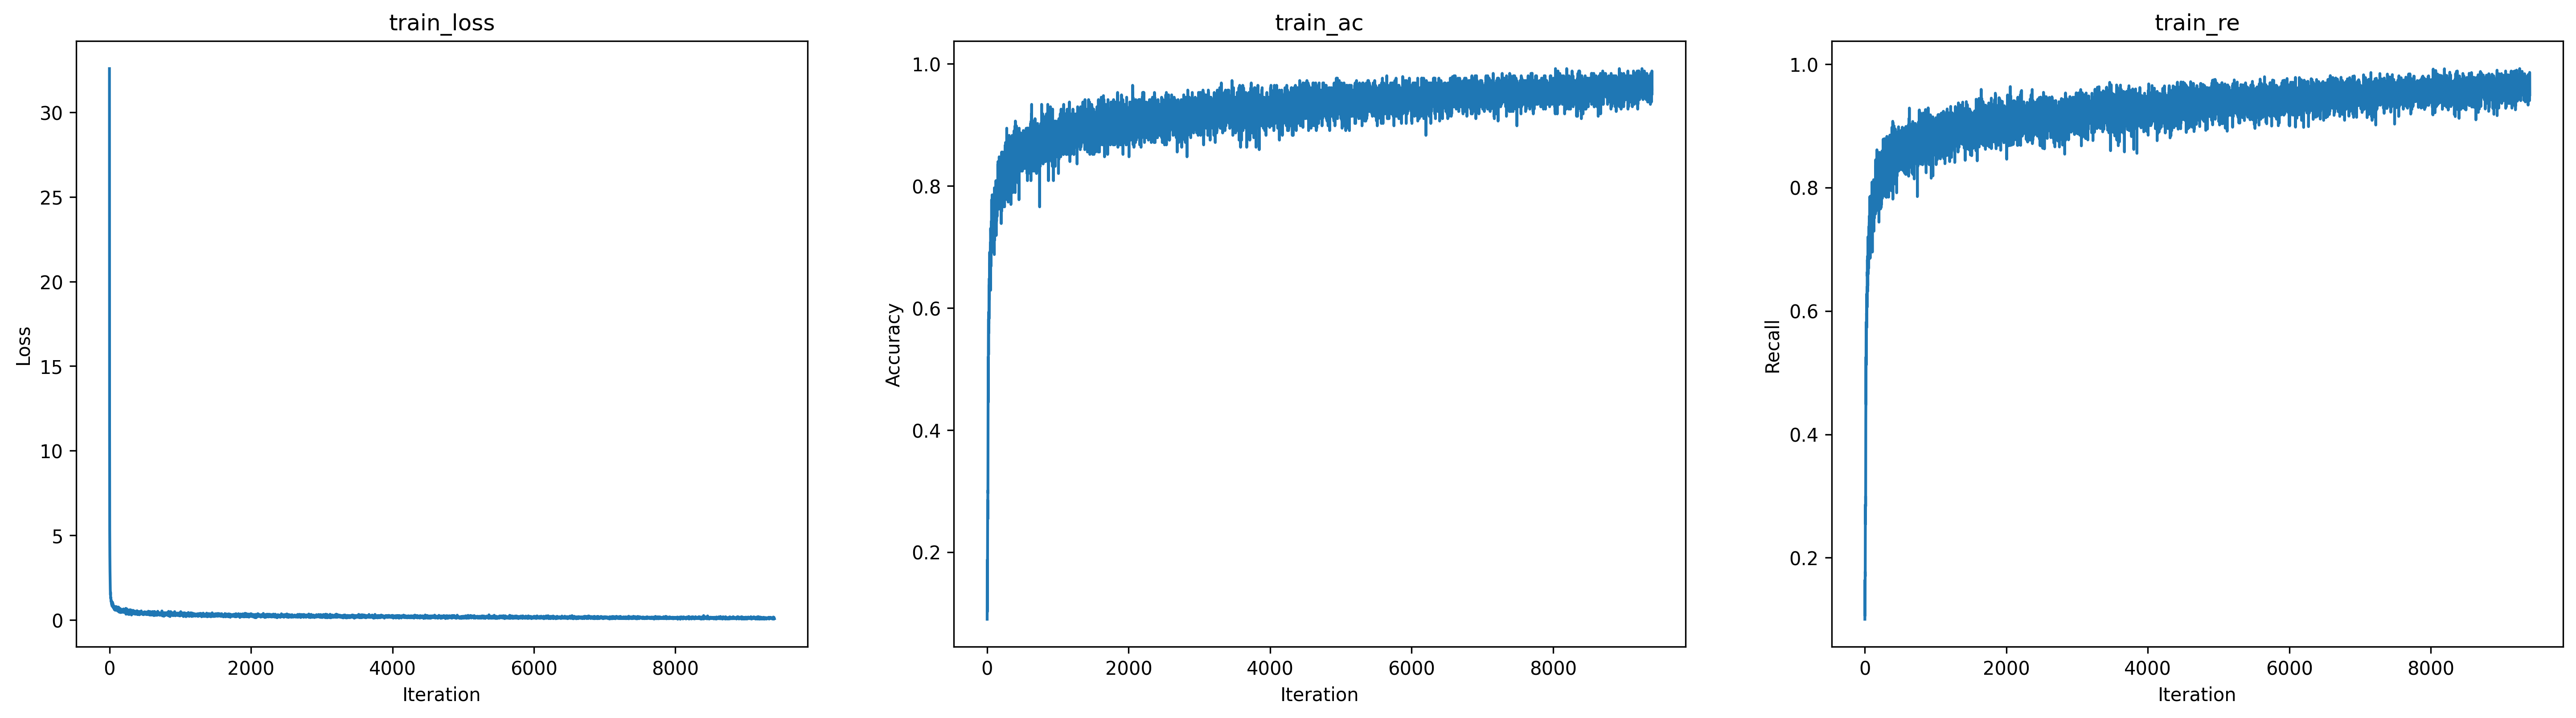

In [6]:
from matplotlib import pyplot as plt
plt.figure(dpi=300,figsize=(24,6))
plt.subplot(1,3,1)
plt.plot(train_loss)
plt.title('train_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1,3,2)
plt.plot(train_ac)
plt.title('train_ac')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(train_re)
plt.title('train_re')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.show()

In [7]:
def test(model, test_iter, loss):   
    y_real = []
    y_pred = []
    total_loss = []
    state_dict=torch.load('save/0259week3.pth')
    model.load_state_dict(state_dict)
    model.to(device) 
    # 将模型设置为验证模式
    model.eval()
    with torch.no_grad():
        for X, y in test_iter:
            y_real.extend(np.array(y).tolist())
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            total_loss.append(l.item())
            y_pred.extend(y_hat.argmax(dim=1).tolist())
            
    
    f1 = f1_score(y_true=y_real, y_pred=y_pred, average='macro')
    ac = accuracy_score(y_true=y_real, y_pred=y_pred)
    re = recall_score(y_true=y_real, y_pred=y_pred,average='macro')
    #au = roc_auc_score(y_true=y_real, y_score=y_pred,multi_class='ovo')
    conf = confusion_matrix(y_true=y_real, y_pred=y_pred, labels=None, sample_weight=None)
    list_wrong = []
    for i in range(len(y_real)):
        if y_real[i] != y_pred[i] :
            list_wrong.append(i)
    
    return (sum(total_loss)/len(total_loss),f1,re,ac,conf,y_pred,list_wrong)
        

test_loss,test_f1,test_re,test_ac,test_conf,y_pred,list_wrong = test(model, test_iter, loss)
print('test_loss = %.2f'%test_loss)
print('test_f1 = %.2f'%test_f1)
print('test_recall = %.2f'%test_re)
print('test_accuracy = %.2f'%test_ac)
print('confusion_matrix:')
print(test_conf)

test_loss = 0.26
test_f1 = 0.92
test_recall = 0.92
test_accuracy = 0.92
confusion_matrix:
[[890   1  10  14   4   1  73   0   7   0]
 [  5 984   0   7   1   0   1   0   2   0]
 [ 25   0 885   6  51   0  32   0   1   0]
 [ 18   5   8 930  24   0  13   0   1   1]
 [  1   0  40  28 890   1  38   0   2   0]
 [  0   0   0   0   0 981   0  15   0   4]
 [123   0  66  18  66   0 725   0   2   0]
 [  0   0   0   0   0   6   0 974   0  20]
 [  4   0   4   1   0   3   1   2 985   0]
 [  1   0   0   0   0   6   0  25   0 968]]


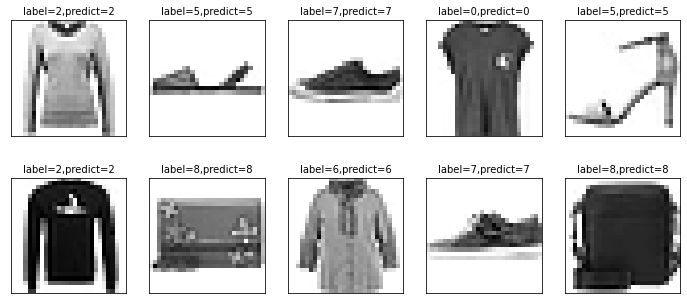

In [8]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: 
        num=25
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title="label="+str(labels[idx])
        if len(prediction)>0: 
            title+=",predict="+str(prediction[idx]) 
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);
        ax.set_yticks([])        
        idx+=1
    plt.show()
plot_images_labels_prediction(x_test,y_test,y_pred,idx=110)

In [9]:
print(list_wrong[:10])

[12, 23, 25, 40, 42, 43, 67, 68, 89, 107]


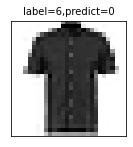

In [11]:
plot_images_labels_prediction(x_test,y_test,y_pred,idx=40,num=1)

In [ ]:
'''
与线性神经网络相比，二维卷积神经网络能够达到更小的Loss与更高的精度。其对比优势有以下几点：

1.局部感知野和权值共享：CNN通过使用卷积层和池化层来构建局部感知野，并共享权值来捕捉图像中的局部模式。这使得CNN能够更好地处理图像中的空间结构信息，而不受图像平移和尺度变化的影响。

2.参数数量减少：相比于MLP，CNN模型的参数数量要少得多。CNN的卷积层使用相同的权值进行滑动窗口计算，从而减少了需要学习的参数数量。这使得CNN更容易优化和训练，并且能够在相对较少的数据上取得好的结果。

3.特征的自动提取：CNN模型通过堆叠多个卷积层和池化层，能够自动学习图像中的特征，从低级特征（如边缘和纹理）到高级特征（如形状和物体部件）。这种层次化的特征提取使得CNN在处理复杂的图像分类任务上表现出色。

4.减少过拟合的效果：CNN模型中常用的正则化技术，如Dropout和批量标准化（Batch Normalization），可以有效减少过拟合的发生。这些技术可以帮助模型更好地泛化到新的未见过的数据。

总的来说，相比于MLP模型，CNN模型在图像分类任务上具有更好的性能和效果。它能够更好地捕捉图像中的特征和结构信息，并且能够有效减少参数数量和过拟合的问题。
在收敛速度和分类准确率方面，CNN通常能够在较短的时间内收敛，并获得更高的准确率。
'''